# Evaluation: Legal Document Similarity

In [80]:
import json
import os
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tabulate
from tqdm import tqdm_notebook as tqdm

import numpy as np

from nltk.corpus import stopwords

from utils import get_mean_avg_precision, get_avg_precision

from methods import TfIdfRecSys, Doc2VecRecSys, BibliographicCouplingRecSys, CPARecSys

In [2]:
out_dir = './out'
methods = ['tfidf', 'doc2vec', 'cpa', 'bibcoup', 'cocit',]

In [3]:
data_dir = './data'
model_dir = './models'

In [4]:
with open(os.path.join(data_dir, 'wikisource_oid2relevant_oids.pickle'), 'rb') as f:
    oid2relevant_oids = pickle.load(f)

print(f'Relevance data for {len(oid2relevant_oids)} opinions from WikiSource')

Relevance data for 1546 opinions from WikiSource


In [5]:
with open(os.path.join(data_dir, 'cat2oids.pickle'), 'rb') as f:
    cat2oids = pickle.load(f)
    
    oid2cat = {oid: cat for cat in cat2oids for oid in cat2oids[cat]}
    
print(f'Categories found: {len(cat2oids)}')

Categories found: 64


In [6]:
# Load dataframe from CSV
with open(os.path.join(data_dir, 'dataframe.csv'), 'r') as f:
    df = pd.read_csv(f)
df.head()

,id,absolute_url,category,rel_count,text_length,tfidf_rel,tfidf_p,tfidf_r,tfidf_avg_p,doc2vec_rel,...,bibcoup_ret,bibcoup_rel,bibcoup_p,bibcoup_r,bibcoup_avg_p,cocit_ret,cocit_rel,cocit_p,cocit_r,cocit_avg_p
0,118181,/opinion/118181/oncale-v-sundowner-offshore-se...,United States Supreme Court decisions on sexua...,0,2399,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,88178,/opinion/88178/the-maggie-hammond/,United States Supreme Court decisions on admir...,130,9610,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
2,106936,/opinion/106936/beck-v-ohio/,United States Supreme Court decisions on the F...,39,4407,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,88528,/opinion/88528/the-java/,United States Supreme Court decisions on admir...,130,3387,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4,106170,/opinion/106170/monroe-v-pape/,United States Supreme Court decisions on civil...,93,32933,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


In [7]:
df.columns

Index(['id', 'absolute_url', 'category', 'rel_count', 'text_length',
       'tfidf_rel', 'tfidf_p', 'tfidf_r', 'tfidf_avg_p', 'doc2vec_rel',
       'doc2vec_p', 'doc2vec_r', 'doc2vec_avg_p', 'case_name', 'year_filed',
       'judges', 'citation_count', 'ingoing_citation_count',
       'outgoing_citation_count', 'tfidf_ret', 'doc2vec_ret', 'cpa_ret',
       'cpa_rel', 'cpa_p', 'cpa_r', 'cpa_avg_p', 'bibcoup_ret', 'bibcoup_rel',
       'bibcoup_p', 'bibcoup_r', 'bibcoup_avg_p', 'cocit_ret', 'cocit_rel',
       'cocit_p', 'cocit_r', 'cocit_avg_p'],
      dtype='object')

In [8]:
# Load pre-trained models

In [9]:
with gzip.open(os.path.join(model_dir, 'doc2vec.pickle.gz'), 'rb') as f:
    doc2vec = pickle.load(f)

In [10]:
with gzip.open(os.path.join(model_dir, 'tfidf.pickle.gz'), 'rb') as f:
    tfidf = pickle.load(f)

In [11]:
with gzip.open(os.path.join(model_dir, 'bibcoup.pickle.gz'), 'rb') as f:
    bibcoup = pickle.load(f)

In [12]:
with gzip.open(os.path.join(model_dir, 'cpa.pickle.gz'), 'rb') as f:
    cpa = pickle.load(f)

In [13]:
cpa_alpha = -0.4
print(f'CPA corpus consists of {len(cpa.oid2id)} opinions')

CPA corpus consists of 1007922 opinions


In [14]:
# Generate and evaluate recommendations
queries_retrieved_docs = {m: {} for m in methods}
queries_relevant_docs = {m: {} for m in methods}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    #if idx > 9999:
    #    break
        
    seed_id = row['id']
    
    rel_docs = oid2relevant_oids[seed_id]
    
    row_top_k = len(rel_docs)
    
    tfidf.top_k = row_top_k
    doc2vec.top_k = row_top_k
    bibcoup.top_k = row_top_k
    
    cpa.alpha = cpa_alpha
    cpa.top_k = row_top_k
    
    cpa_ret_docs = cpa.retrieve_recommendations(seed_id)
    
    cpa.alpha = 0. # cpa with alpha = 0 equals cocit
    cocit_ret_docs = cpa.retrieve_recommendations(seed_id)
    
    for name, ret_docs in [
            ('tfidf', tfidf.retrieve_recommendations(seed_id)),
            ('doc2vec', doc2vec.retrieve_recommendations(seed_id)),
            ('bibcoup', bibcoup.retrieve_recommendations(seed_id)),
            ('cocit', cocit_ret_docs),
            ('cpa', cpa_ret_docs),        
            ]:
        
        queries_retrieved_docs[name][seed_id] = ret_docs
        
        rel_ret_docs_count = len(set(ret_docs) & set(rel_docs))

        df.at[idx, f'{name}_ret'] = len(set(ret_docs))
        df.at[idx, f'{name}_rel'] = rel_ret_docs_count

        if len(ret_docs) > 0 and len(rel_docs) > 0:
            # Precision = No. of relevant documents retrieved / No. of total documents retrieved
            df.at[idx, f'{name}_p'] = rel_ret_docs_count / len(ret_docs)

            # Recall = No. of relevant documents retrieved / No. of total relevant documents
            df.at[idx, f'{name}_r'] = rel_ret_docs_count / len(rel_docs)
            
            df.at[idx, f'{name}_avg_p'] = get_avg_precision(ret_docs, rel_docs)
            
            # TODO Recall@K

In [15]:
# Write evaluated df to csv
with open(os.path.join(out_dir, 'evaluted_df.csv'), 'w') as f:
    df.to_csv(f, index=False)

In [52]:
# Hybrid-best 
df['best_avg_p'] = 0.
df['best_ret'] = 0.
df['best_rel'] = 0.
df['best_p'] = 0.
df['best_r'] = 0.
df['best_method'] = ''

for idx, row in df.iterrows():
    best_p = 0.
    best_m = None
    
    for m in methods:
        avg_p = row[f'{m}_avg_p']
        print(avg_p)
        if avg_p > best_p:
            best_p = avg_p
            
            df.at[idx, 'best_avg_p'] = avg_p
            df.at[idx, 'best_ret'] = row[f'{m}_ret']
            df.at[idx, 'best_rel'] = row[f'{m}_rel']
            df.at[idx, 'best_p'] = row[f'{m}_p']
            df.at[idx, 'best_r'] = row[f'{m}_r']            
            
            df.at[idx, 'best_method'] = m
            
df

0.0
0.0
0.0
0.0
0.0
0.0964938242433053
0.13022239448571055
0.024372469635627527
0.0
0.03741133866133867
0.20075240426902832
0.09342827010320807
0.565157677903426
0.37163482392095315
0.5400352273764468
0.36317841980548715
0.5529612780159501
0.007692307692307693
0.0
0.007692307692307693
0.006488251294417574
0.024780317952360964
0.012808835067607705
0.007666336209783655
0.010189406904039784
0.13087762938798136
0.03156188653387623
0.006944444444444444
0.0
0.0023148148148148147
0.04252969126691481
0.07195542929748823
0.0016996891996891997
0.0
0.003472222222222222
0.012646234742449896
0.0003561253561253561
0.007234432234432235
0.018201429980276133
0.0125
0.06422548319614522
0.14889377693186742
0.009213172448466566
0.0
0.007450980392156863
0.0054329573079573085
0.009320953495175017
0.0
0.0
0.0
0.047947775909840916
0.06738376359167692
0.002626411389297987
0.016761491357259125
0.00164449110225137
0.0
0.002857142857142857
0.04
0.004
0.04
0.012987012987012986
0.0
0.0
0.0
0.0
0.16666666666666666
0

0.10855898992405401
0.06357221258232841
0.0
0.0
0.0
0.03112198673857994
0.008967242451465244
0.0
0.0
0.0
0.0
0.0
0.05555555555555555
0.0
0.07692307692307693
0.07142857142857142
0.0
0.02040816326530612
0.1285714285714286
0.0
0.03426503214769663
0.14860914214261195
0.0
0.0
0.0
0.005196984410696657
0.00859177809600219
0.387553310940653
0.07732835566064601
0.42658689235405667
0.04584868863102134
0.04284307088040771
0.0
0.013770250368188514
0.0
0.031305690947061274
0.021379157091205418
0.043653201982688856
0.06071757899699973
0.036205905700566525
0.03150169097324998
0.015260356749909403
0.0
0.0
0.0
0.08263089219418644
0.1563442667688699
0.0039008870172958297
0.0
0.0037514988748172605
0.03655453811526931
0.021663744834048714
0.01702519740068357
0.021424480445099
0.016440800053160683
0.03435366075901736
0.06171016322252444
0.0
0.0
0.0
0.015480475250590193
0.0021645021645021645
0.0761183261183261
0.1294766532998564
0.09435261707988982
0.12102975633217006
0.05118579906723867
0.0
0.0
0.0
0.02928

0.005760944666235093
0.00030148423005565863
0.03927217790571402
0.06732004568267137
0.039529306491082564
0.07432960361995004
0.07570327891305481
0.048285678591743576
0.02960725778869118
0.04298700802961392
0.01812011170498228
0.13028005988981886
0.2773790022449048
0.2525393354513217
0.2746300588646249
0.0076719591252111564
0.034308275687586036
0.10286110286110287
0.04247104247104247
0.1006006006006006
0.018379103535353533
0.036804328388399664
0.031567662549919585
0.07194089601404186
0.030459161211896162
0.05424030577262229
0.037255041927673066
0.20777314643726053
0.08491921205948735
0.23209932158978366
0.41830771264695926
0.5506439830706932
0.09230769230769231
0.007692307692307693
0.08960641922180383
0.07692307692307693
0.0
0.038461538461538464
0.0989010989010989
0.008547008547008546
0.058135858359593444
0.10245674686413875
0.020240590708906787
0.01509538265560694
0.016798385313966577
0.026450652424153436
0.017961991761937395
0.10787790106600646
0.0633636659346217
0.09182319386995665
0

0.04213071527889613
0.023250387868355933
0.0
0.001718213058419244
0.0
0.003772161334026115
0.02183010272659112
0.03635728724323126
0.0
0.042249326557083446
0.045627325659683395
0.0186905347324258
0.015499482784627512
0.005154639175257732
0.017391524068166037
0.054997218121711065
0.022325787781002807
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004612323187466658
0.0017439362108479758
0.0
0.0
0.0
0.06292957843107674
0.0275422674981778
0.0
0.0
0.0
0.21095506087766147
0.28538110432143177
0.7168657879114371
0.5884631197777084
0.703786340015014
0.16666666666666666
0.0
0.3333333333333333
0.0
0.3333333333333333
0.005225992548507761
0.009756645540741975
0.004761904761904762
0.0
0.004761904761904762
0.001058201058201058
0.0013605442176870747
0.0
0.0
0.0
0.023304716196297988
0.012331035283481498
0.3965741813120468
0.23108081811102243
0.39180126588969605
0.0101010101010101
0.0010822510822510823
0.0
0.0
0.0
0.10223279034951106
0.035079314181025736
0.25625084450729624
0.18018357546165523
0.2445631336925657
0.

0.02303417666380198
0.0
0.0
0.0
0.13659863945578232
0.004081632653061224
0.05134199134199134
0.0
0.07632653061224491
0.004342619190572821
0.009698801403511464
0.0
0.0
0.0
0.10424242424242426
0.004
0.08
0.0
0.08
0.0
0.0
1.0
0.0
1.0
0.37326595820149355
0.16854450827211528
0.5275247008800832
0.5133305870686005
0.5472937048807777
0.017589515139561012
0.000884703196347032
0.00019594026603372396
0.0
0.0
0.052986788585823855
0.10956632950908003
0.016865079365079364
0.0
0.008060515873015872
0.0038338268920793195
0.0016177349510682845
0.0
0.0
0.0
0.004571544670554571
0.012606186652854755
0.029922779922779922
0.0
0.02691977691977692
0.059009652980851285
0.0012478191333556677
0.0
0.0
0.0
0.053636506688713906
0.5985135342450655
0.0
0.0
0.0
0.04327831592841275
0.00020461811242759466
0.0
0.0
0.0
0.08346126566649935
0.10389178428850826
0.004484304932735426
0.0
0.004484304932735426
0.03378121078831984
0.09809420018911233
0.16660625752861183
0.10347882917261768
0.177193134340776
0.0
0.0
0.0
0.0
0.02561

,id,absolute_url,category,rel_count,text_length,tfidf_rel,tfidf_p,tfidf_r,tfidf_avg_p,doc2vec_rel,...,cocit_rel,cocit_p,cocit_r,cocit_avg_p,best_avg_p,best_method,best_ret,best_rel,best_p,best_r
0,118181,/opinion/118181/oncale-v-sundowner-offshore-se...,United States Supreme Court decisions on sexua...,0,2399,0,0.000000,0.000000,0.000000,0,...,0,0.000000,0.000000,0.000000,0.000000,,0.0,0.0,0.000000,0.000000
1,88178,/opinion/88178/the-maggie-hammond/,United States Supreme Court decisions on admir...,130,9610,28,0.217054,0.215385,0.096494,38,...,8,0.363636,0.061538,0.037411,0.130222,doc2vec,130.0,38.0,0.292308,0.292308
2,106936,/opinion/106936/beck-v-ohio/,United States Supreme Court decisions on the F...,39,4407,11,0.289474,0.282051,0.200752,10,...,24,0.615385,0.615385,0.540035,0.565158,cpa,39.0,24.0,0.615385,0.615385
3,88528,/opinion/88528/the-java/,United States Supreme Court decisions on admir...,130,3387,63,0.488372,0.484615,0.363178,82,...,1,1.000000,0.007692,0.007692,0.552961,doc2vec,130.0,82.0,0.630769,0.630769
4,106170,/opinion/106170/monroe-v-pape/,United States Supreme Court decisions on civil...,93,32933,5,0.054348,0.053763,0.006488,13,...,10,0.107527,0.107527,0.010189,0.024780,doc2vec,93.0,13.0,0.139785,0.139785
5,89786,/opinion/89786/county-of-macon-v-shores/,United States Supreme Court decisions on secur...,144,2625,33,0.230769,0.229167,0.130878,23,...,1,0.200000,0.006944,0.002315,0.130878,tfidf,143.0,33.0,0.230769,0.229167
6,89505,/opinion/89505/waite-v-dowley/,United States Supreme Court decisions on secur...,144,2991,23,0.160839,0.159722,0.042530,35,...,2,0.153846,0.013889,0.003472,0.071955,doc2vec,144.0,35.0,0.243056,0.243056
7,95526,/opinion/95526/dayton-coal-iron-co-v-barton/,United States Supreme Court decisions on the F...,104,790,10,0.097087,0.096154,0.012646,1,...,3,0.250000,0.028846,0.012500,0.018201,bibcoup,17.0,6.0,0.352941,0.057692
8,89913,/opinion/89913/platt-v-union-pacific-r-co/,United States Supreme Court decisions on antit...,255,7840,57,0.224409,0.223529,0.064225,87,...,4,0.307692,0.015686,0.007451,0.148894,doc2vec,255.0,87.0,0.341176,0.341176
9,92488,/opinion/92488/badeau-v-united-states/,United States Supreme Court decisions on antit...,111,4286,6,0.054545,0.054054,0.005433,8,...,0,0.000000,0.000000,0.000000,0.009321,doc2vec,111.0,8.0,0.072072,0.072072


In [53]:
df['best_method'].value_counts()

tfidf      479
doc2vec    468
cpa        214
cocit      178
bibcoup    149
            58
Name: best_method, dtype: int64

0    1544
1       2
Name: best_avg_p, dtype: int64

# Results

In [91]:
metrics = [
    'ret',
    'rel',
    'p',
    'r',
    'map',
]
methods_with_best = methods + ['best']
round_by = 4

overall = []

for method in methods_with_best:
    overall.append({
        'name': method,
        'ret': round(df[f'{method}_ret'].mean(), 1),
        'rel': round(df[f'{method}_rel'].mean(), 1),
        'p': round(df[f'{method}_p'].mean(), round_by),
        'r': round(df[f'{method}_r'].mean(), round_by),
        'map': round(df[f'{method}_avg_p'].mean(), round_by),
        #'std_ap': df[f'{method}_avg_p'].std(),
    
    })
    
odf = pd.DataFrame(overall).transpose()

with open('tables/overall.csv', 'w') as f:
    odf.to_csv(f)

odf

,0,1,2,3,4,5
name,tfidf,doc2vec,cpa,bibcoup,cocit,best
ret,134.5,129.5,37.5,22,37.5,121.3
rel,28.3,30.8,11.1,7.6,11.1,37
p,0.1811,0.1905,0.266,0.191,0.2647,0.2994
r,0.1776,0.1905,0.1196,0.0848,0.1183,0.2672
map,0.0676,0.0759,0.0794,0.0553,0.0773,0.1488


In [109]:
print(tabulate.tabulate(odf.values, tablefmt="pipe"))


|:-------|:--------|:-------|:--------|:-------|:-------|
| tfidf  | doc2vec | cpa    | bibcoup | cocit  | best   |
| 134.5  | 129.5   | 37.5   | 22.0    | 37.5   | 121.3  |
| 28.3   | 30.8    | 11.1   | 7.6     | 11.1   | 37.0   |
| 0.1811 | 0.1905  | 0.266  | 0.191   | 0.2647 | 0.2994 |
| 0.1776 | 0.1905  | 0.1196 | 0.0848  | 0.1183 | 0.2672 |
| 0.0676 | 0.0759  | 0.0794 | 0.0553  | 0.0773 | 0.1488 |


In [63]:
# Folds
from sklearn.model_selection import KFold
import math

k = 10
rdf = df.sample(frac=1) # random_state
limit = math.ceil(len(rdf)/k)
maps = {method: [] for method in methods_with_best}

for i in range(k):
    offset = i * limit
    end = offset + limit
    
    fold = rdf[offset:end]
    
    for method in methods_with_best:
        maps[method].append(fold[f'{method}_avg_p'].mean())
    

std_map = {method: np.std(maps[method]) for method in methods_with_best}

In [111]:
# Std. deviation of MAP on 10 folds
stddf = pd.DataFrame([std_map])
stddf

,tfidf,doc2vec,cpa,bibcoup,cocit,best
0,0.007903,0.011604,0.010463,0.007245,0.010708,0.015004


In [19]:
# Categories with correct predictions
f_cats = set(
    df[(df['tfidf_rel'] > 1) | 
       (df['doc2vec_rel'] > 1) | 
       (df['bibcoup_rel'] > 1) |
       (df['cpa_rel'] > 1)
      ]['category'].values)

fdf = df[df['category'].isin(f_cats)]

# Make the category lables more readiable
def clean_cat(c):
    return c.replace('United States Supreme Court decisions on ', '')\
    .replace('United States Supreme Court decisions involving ', '')\
    .replace('United States Supreme Court', 'SCOTUS').title()

clean_f_cats = [
    clean_cat(c) for c in f_cats]

print(f'Filtered categories: {len(f_cats)}')

Filtered categories: 51


In [20]:
# Table
group = fdf.groupby(['category'])

#         .join(group['bibcoup_avg_p'].mean().rename('BibCoup').to_frame()) \
gdf = group['rel_count'].mean().rename('Gold docs').to_frame() \
        .join(group['tfidf_avg_p'].mean().rename('TF-IDF').to_frame()) \
        .join(group['doc2vec_avg_p'].mean().rename('Doc2Vec').to_frame()) \
        .join(group['cpa_avg_p'].mean().rename('CPA').to_frame()) \
        .join(group['bibcoup_avg_p'].mean().rename('BibCoup.').to_frame()) \

#with open('tables/map_by_category.csv', 'w') as f:
#    gdf.to_csv(f)

with pd.option_context('precision', 4):
    # top 3
    display(gdf.sort_values(['Gold docs'], ascending=False)[:3])

    # mid 3
    mid = round(len(gdf) / 2)
    print(mid)
    display(gdf.sort_values(['Gold docs'], ascending=False)[mid:mid+3])

    # low 3
    display(gdf.sort_values(['Gold docs'], ascending=False)[-3:])
    print(len(gdf))


,Gold docs,TF-IDF,Doc2Vec,CPA,BibCoup.
category,,,,,
United States Supreme Court decisions on treaties,223.0000,0.1305,0.1189,0.0104,0.0030
United States Supreme Court decisions on due process,203.0405,0.0529,0.0482,0.0199,0.0128
United States Supreme Court decisions on the Ex Post Facto Clause,174.0000,0.0267,0.0557,0.0478,0.0145


26


,Gold docs,TF-IDF,Doc2Vec,CPA,BibCoup.
category,,,,,
United States Supreme Court decisions on administrative law,66.1000,0.0057,0.0195,0.0521,0.0252
United States Supreme Court decisions on the Fourth Amendment,62.9412,0.1982,0.1228,0.4843,0.4238
United States Supreme Court decisions on criminal procedure,62.2500,0.0249,0.0238,0.0911,0.0560


,Gold docs,TF-IDF,Doc2Vec,CPA,BibCoup.
category,,,,,
United States Supreme Court decisions on the Eleventh Amendment,3.0,0.1250,0.0278,0.5000,0.0833
United States Supreme Court decisions on the Sixteenth Amendment,3.0,0.1250,0.0000,0.2917,0.0972
United States Supreme Court decisions on Article V,3.0,0.0833,0.0000,0.3333,0.0833


51


In [21]:
# top k
min_docs_per_category_count = 10

fdf = df[df['category'].isin(f_cats)]  #.groupby('category').filter(lambda x: len(x) >= min_docs_per_category_count)

fdf['category'].value_counts()

United States Supreme Court decisions on treaties                                181
United States Supreme Court decisions on due process                             148
United States Supreme Court decisions on admiralty                               131
United States Supreme Court decisions on securities                              125
United States Supreme Court decisions on antitrust                                99
United States Supreme Court decisions on the First Amendment                      94
United States Supreme Court decisions on evidence                                 83
United States Supreme Court decisions on civil procedure                          77
United States Supreme Court decisions on civil rights                             71
United States Supreme Court decisions on the Fifth Amendment                      51
United States Supreme Court decisions on the Fourteenth Amendment                 48
United States Supreme Court decisions on intellectual property   

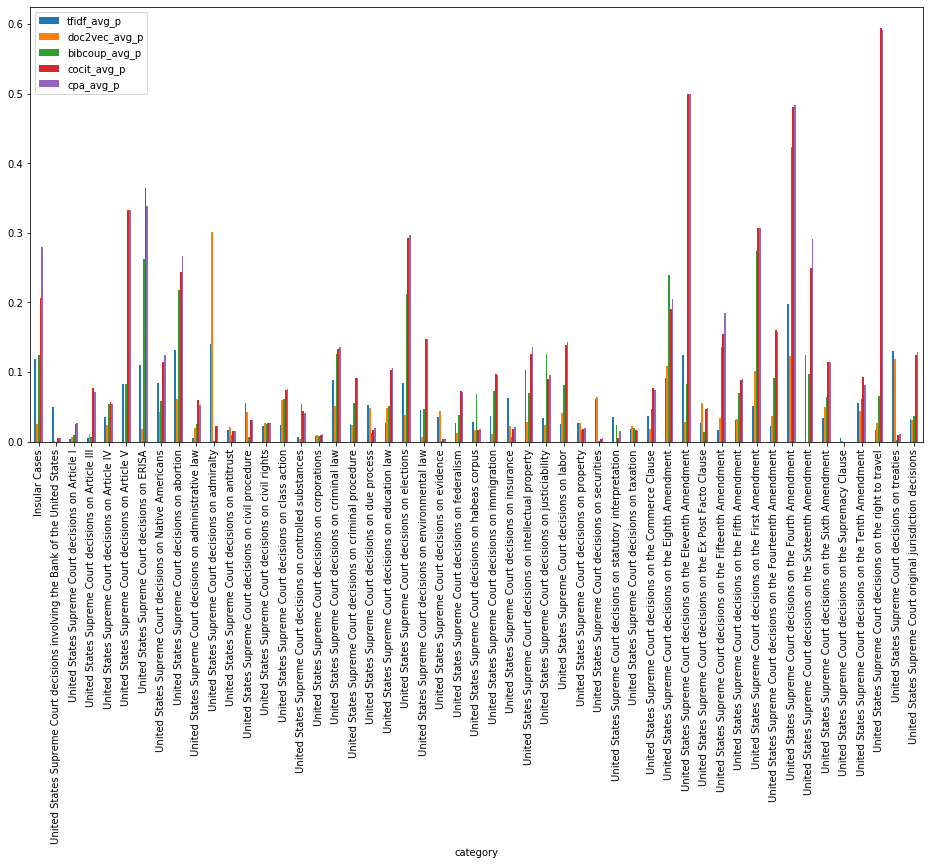

In [22]:
fdf.groupby(['category'])['tfidf_avg_p', 'doc2vec_avg_p', 'bibcoup_avg_p', 'cocit_avg_p',  'cpa_avg_p'].mean().plot(kind='bar', 
    figsize=(16, 8), )

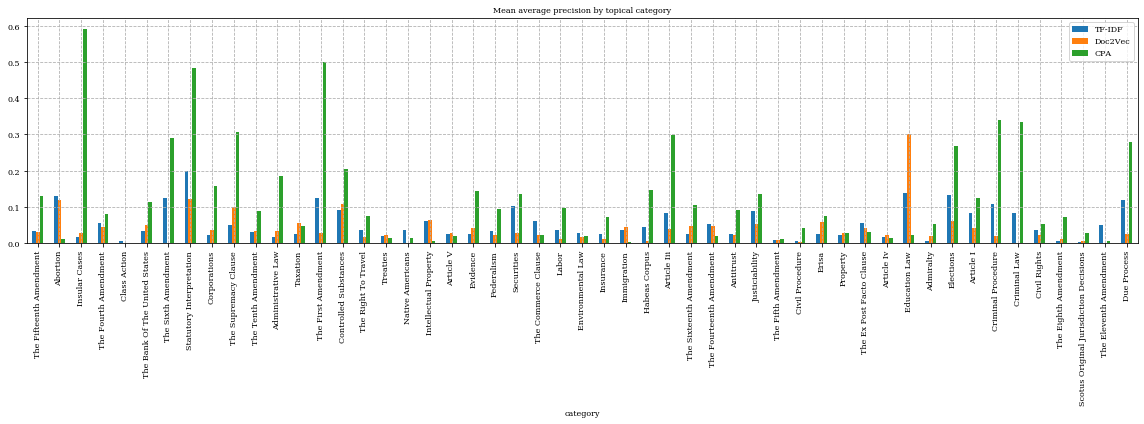

In [69]:
group = fdf.groupby(['category'])

#         .join(group['bibcoup_avg_p'].mean().rename('BibCoup').to_frame()) \
gdf = group['tfidf_avg_p'].mean().rename('TF-IDF').to_frame() \
        .join(group['doc2vec_avg_p'].mean().rename('Doc2Vec').to_frame()) \
        .join(group['cpa_avg_p'].mean().rename('CPA').to_frame()) \
        

#gdf['category'] = clean_f_cats

# sort_index(ascending=False)
ax = gdf.sort_index(ascending=False).plot(
    kind='bar', 
    figsize=(16, 6), 
    title='Mean average precision by topical category',
    rot=90
)
ax.set_xticklabels(clean_f_cats)

plt.grid()
plt.tight_layout()
plt.savefig('figures/map_by_category.png')

# Paper figures

In [24]:
plot_methods = {  # we leave out CoCit, bc not different to CPA
    'tfidf': 'TF-IDF',
    'doc2vec': 'Doc2Vec',
    'cpa': 'CPA',
    'bibcoup': 'Bibliographic Coupling'
}

In [25]:
fig_width = 8
fig_height = 4

params = {
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    #'text.fontsize': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
}

matplotlib.rcParams.update(params)

## Text length

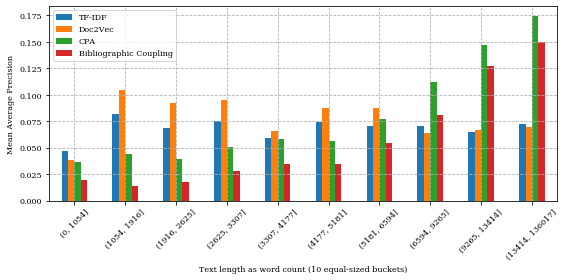

In [70]:
# quantile based bins (all bins are equal sized -> decentile)
q = 10
bins, s = pd.qcut(fdf['text_length'], q=q, retbins=True)

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(f"Text length as word count ({q} equal-sized buckets)")
ax.set_ylabel("Mean Average Precision")

plt.grid()
plt.tight_layout()

plt.savefig(f'figures/map_by_text_length_q{q}.pdf')
plt.savefig(f'figures/map_by_text_length_q{q}.png')

#with open('tables/map_by_text_length.csv', 'w') as f:
#    xdf.to_csv(f)

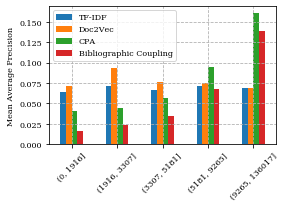

In [27]:
q = 5
bins, s = pd.qcut(fdf['text_length'], q=q, retbins=True)

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
    figsize=(4,3),
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
#ax.set_xlabel(f"Text length as word count ({q} equal-sized buckets)")
ax.set_xlabel(None)

ax.set_ylabel("Mean Average Precision")

plt.grid()
plt.tight_layout()

plt.savefig('figures/map_by_text_length_q5.pdf')

## Citations

### Ingoing citations

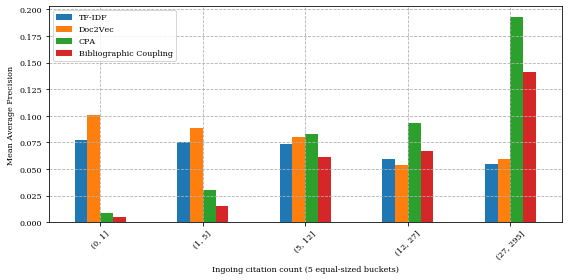

In [28]:
q = 5
bins, s = pd.qcut(fdf['ingoing_citation_count'], q=q, retbins=True)

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(f"Ingoing citation count ({q} equal-sized buckets)")
ax.set_ylabel("Mean Average Precision")

plt.grid()

plt.tight_layout()
plt.savefig('figures/map_by_ingoing_citation_count_q5.pdf')


### Ingoing (from CL meta data)

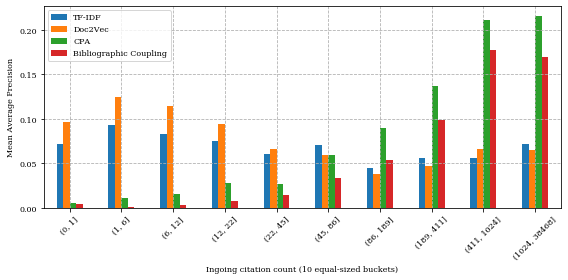

In [71]:
# quantile based bins (all bins are equal sized -> decentile)
q = 10
bins, s = pd.qcut(fdf['citation_count'], q=q, retbins=True)

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(f"Ingoing citation count ({q} equal-sized buckets)")
ax.set_ylabel("Mean Average Precision")

plt.grid()

plt.tight_layout()
plt.savefig(f'figures/map_by_ingoing_citation_count_q{q}.pdf')
plt.savefig(f'figures/map_by_ingoing_citation_count_q{q}.png')


### Outgoing citations 

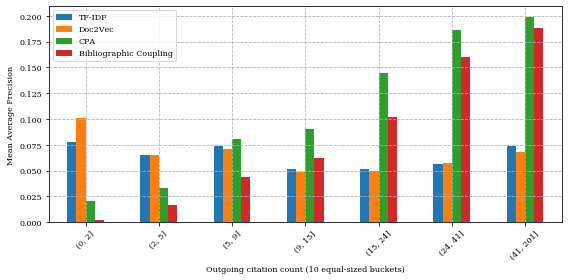

In [73]:
q = 10
bins, s = pd.qcut(fdf['outgoing_citation_count'], q=q, retbins=True, duplicates='drop')

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(f"Outgoing citation count ({q} equal-sized buckets)")
ax.set_ylabel("Mean Average Precision")

plt.grid()

plt.tight_layout()
plt.savefig(f'figures/map_by_outgoing_citation_count_q{q}.pdf')
plt.savefig(f'figures/map_by_outgoing_citation_count_q{q}.png')


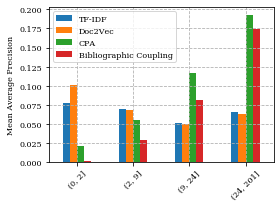

In [30]:
q = 5
bins, s = pd.qcut(fdf['outgoing_citation_count'], q=q, retbins=True, duplicates='drop')

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
    figsize=(4,3),
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
#ax.set_xlabel(f"Outgoing citation count ({q} equal-sized buckets)")
ax.set_xlabel(None)
ax.set_ylabel("Mean Average Precision")

plt.grid()

plt.tight_layout()
plt.savefig(f'figures/map_by_outgoing_citation_count_q{q}.pdf')

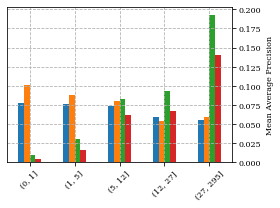

In [31]:
# quantile based bins (all bins are equal sized -> decentile)
q = 5
bins, s = pd.qcut(fdf['ingoing_citation_count'], q=q, retbins=True)

xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
    figsize=(4,3),
    legend=False,
)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

#ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
#ax.set_xlabel(f"Citation count ({q} equal-sized buckets)")
ax.set_xlabel(None)
ax.set_ylabel("Mean Average Precision")

plt.grid()

plt.tight_layout()
plt.savefig('figures/map_by_ingoing_citation_count_q5.pdf')

#with open('tables/map_by_citation_count.csv', 'w') as f:
#    xdf.to_csv(f)

## Year

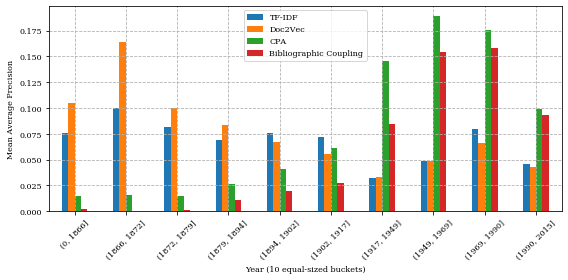

In [74]:
# quantile based bins (all bins are equal sized -> decentile)
q = 10
bins, s = pd.qcut(fdf['year_filed'], q=q, retbins=True)
xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
)

ax.legend(plot_methods.values())
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(f"Year ({q} equal-sized buckets)")
ax.set_ylabel("Mean Average Precision")
plt.grid()

plt.tight_layout()
plt.savefig(f'figures/map_by_year_q{q}.pdf')
plt.savefig(f'figures/map_by_year_q{q}.png')


#with open('tables/map_by_year.csv', 'w') as f:
#    xdf.to_csv(f)

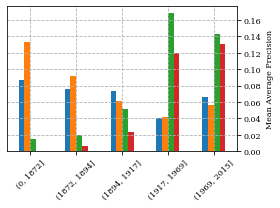

In [33]:
q = 5
bins, s = pd.qcut(fdf['year_filed'], q=q, retbins=True)
xdf = fdf.groupby(bins)[[f'{m}_avg_p' for m in plot_methods]].mean()
ax = xdf.plot(    
    kind='bar', 
    rot=45,
    figsize=(4,3),
    legend=False,
)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
ax.set_xlabel(None)
ax.set_ylabel("Mean Average Precision")
plt.grid()

plt.tight_layout()
plt.savefig(f'figures/map_by_year_q{q}.pdf')

# Correlations

In [34]:
# pearson : standard correlation coefficient

# citation vs year
corr = fdf['ingoing_citation_count'].corr(fdf['year_filed'])
print(f'Pearson correlation coefficient between IN going citation count and year: {corr}')

corr = fdf['outgoing_citation_count'].corr(fdf['year_filed'])
print(f'Pearson correlation coefficient between OUT going citation count and year: {corr}')


# text length vs year
corr = fdf['text_length'].corr(fdf['year_filed'])
print(f'Pearson correlation coefficient between text length and year: {corr}')


# citation vs text-length
corr = fdf['ingoing_citation_count'].corr(fdf['text_length'])
print(f'Pearson correlation coefficient between ingoing_citation_count and text_length: {corr}')

corr = fdf['outgoing_citation_count'].corr(fdf['text_length'])
print(f'Pearson correlation coefficient between OUTgoing_citation_count and text_length: {corr}')


Pearson correlation coefficient between IN going citation count and year: 0.13970935644367563
Pearson correlation coefficient between OUT going citation count and year: 0.28151774628261805
Pearson correlation coefficient between text length and year: 0.07762276513939688
Pearson correlation coefficient between ingoing_citation_count and text_length: 0.3647516732188297
Pearson correlation coefficient between OUTgoing_citation_count and text_length: 0.5979082921067448


## Cartesian product

Plot combined intervals (text length vs citations)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Gradient bg over full table
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]



In [36]:
q = 5

tl_bins, s = pd.qcut(fdf['text_length'], q=q, retbins=True)
cits_bins, s = pd.qcut(fdf['ingoing_citation_count'], q=q, retbins=True)


In [37]:
map_2d = {} 
for method in methods:
    map_2d[method] = {}
    
    for cit_idx, cit_interval in enumerate(cits_bins.cat.categories):
        for tl_idx, tl_interval in enumerate(tl_bins.cat.categories):
            subset = df[(df['ingoing_citation_count'] > int(cit_interval.left)) \
                    & (df['ingoing_citation_count'] <= int(cit_interval.right)) \
                    & (df['text_length'] > int(tl_interval.left)) \
                    & (df['text_length'] <= int(tl_interval.right))]
            idx = (f'({int(cit_interval.left)}, {int(cit_interval.right)}]', f'({int(tl_interval.left)}, {int(tl_interval.right)}]')
            map_2d[method][idx] = subset[f'{method}_avg_p'].mean()

In [38]:
for method in methods:
    print(f'{method}: text_length vs ingoing_citation_count')
    
    s = pd.Series(map_2d[method], index=pd.MultiIndex.from_tuples(map_2d[method]))
    xdf = s.unstack().reindex(s.index.get_level_values(0).unique())
    
    with pd.option_context('precision', 3):
        display(xdf.style.apply(background_gradient,
                       cmap='Reds',
                       m=xdf.min().min(),
                       M=xdf.max().max(),
                       low=0,
                       high=0.3))

tfidf: text_length vs ingoing_citation_count


,"(0, 1916]","(1916, 3307]","(3307, 5181]","(5181, 9265]","(9265, 136017]"
"(0, 1]",0.0806,0.0886,0.064,0.0771,0.0978
"(1, 5]",0.0854,0.0837,0.0713,0.0724,0.0404
"(5, 12]",0.05,0.0598,0.0837,0.099,0.0707
"(12, 27]",0.0469,0.048,0.059,0.0644,0.067
"(27, 295]",0.0294,0.042,0.0374,0.0522,0.0667


doc2vec: text_length vs ingoing_citation_count


,"(0, 1916]","(1916, 3307]","(3307, 5181]","(5181, 9265]","(9265, 136017]"
"(0, 1]",0.125,0.116,0.0896,0.107,0.0911
"(1, 5]",0.0983,0.0998,0.0881,0.0772,0.0415
"(5, 12]",0.0604,0.0939,0.084,0.0852,0.0704
"(12, 27]",0.0335,0.0412,0.0498,0.0625,0.0611
"(27, 295]",0.0189,0.0376,0.0515,0.0607,0.0673


cpa: text_length vs ingoing_citation_count


,"(0, 1916]","(1916, 3307]","(3307, 5181]","(5181, 9265]","(9265, 136017]"
"(0, 1]",0.015,0.0158,0.00798,0.0362,0.0473
"(1, 5]",0.0424,0.018,0.0204,0.0393,0.0444
"(5, 12]",0.0443,0.0496,0.0655,0.104,0.126
"(12, 27]",0.13,0.0573,0.0564,0.081,0.142
"(27, 295]",0.2,0.19,0.17,0.161,0.227


bibcoup: text_length vs ingoing_citation_count


,"(0, 1916]","(1916, 3307]","(3307, 5181]","(5181, 9265]","(9265, 136017]"
"(0, 1]",0.0066,0.00898,0.00367,0.00326,0.0293
"(1, 5]",0.0128,0.00793,0.0126,0.0254,0.03
"(5, 12]",0.0171,0.0182,0.0287,0.0892,0.12
"(12, 27]",0.0533,0.0229,0.0337,0.0613,0.133
"(27, 295]",0.0551,0.119,0.116,0.107,0.178


cocit: text_length vs ingoing_citation_count


,"(0, 1916]","(1916, 3307]","(3307, 5181]","(5181, 9265]","(9265, 136017]"
"(0, 1]",0.0142,0.0159,0.00728,0.0357,0.0412
"(1, 5]",0.0423,0.0171,0.0178,0.0389,0.0428
"(5, 12]",0.044,0.0466,0.0564,0.105,0.124
"(12, 27]",0.133,0.0503,0.0544,0.0785,0.138
"(27, 295]",0.204,0.19,0.166,0.16,0.221
